# Optimization of Gold Recovery Process

# Content
* [Introduction](#intro)
* [Initialization](#initialization)
* [Data Exploration](#data_exploration)
  * [`df_train`](#df_train)
    * [Conclusion](#conclusion)
  * [`df_test`](#df_test)
    * [Conclusion](#conclusion)
  * [`df_full`](#df_full)
    * [Conclusion](#conclusion)
  * [Recovery and MAE calculation](#recovery_MAE)
  * [Analyzing features](#analyzing)
* [Data Preprocessing](#data_preprocessing)
  * [Missing values](#missing_values)
  * [Converting data type](#converting)
  * [Conclusion](#conclusion)
* [Data Analysis](#data_analysis)
  * [Distribution of concentrations of metals (Au, Ag, Pb) across purification stage](#distribution)
  * [Comparing feed particle size distributions](#coparing_feed_particle)
    * [Conclusion](#conclusion)
  * [Distribution of total concentrations of all substances at different stages](#distribution_of_total_conc)
    * [Conclusion](#conclusion)
* [Model Building](#model_building)
  * [Conclusion](#conclusion)
* [Findings](#findings)


## Introduction 

Zyfra, a company that develops efficiency solutions for heavy industry, wants to develop a model to predict the amount of gold recovered from gold ore. Mined ore undergoes primary processing to get the ore mixture (rougher feed) for floatation. The gold ore mixture is fed into the float banks to obtain rougher Au concentrate and rougher tails. The rougher concentrate then undergoes two stages of purification. After purification, we have the final concentrate and new tails. The model created will help optimize the production and eliminate unprofitable parameters.

**Data Description:**
* **Technological process**
  * Rougher feed — raw material
  * Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
    * Xanthate — promoter or flotation activator;
    * Sulphate — sodium sulphide for this particular process;
    * Depressant — sodium silicate.
  * Rougher process — flotation
  * Rougher tails — product residues
  * Float banks — flotation unit
  * Cleaner process — purification
  * Rougher Au — rougher gold concentrate
  * Final Au — final gold concentrate
* **Parameters of stages**
  * air amount — volume of air
  * fluid levels
  * feed size — feed particle size
  * feed rat

**Objectives:**
* Calculate recovery for the `rougher.output.recovery` feature and find MAE between the calculations and feature values
* Compare changes for concentrations of metals (Au, Ag, Pb) during the purification stage
* Compare feed particle size distributions in training and test set
* Compare total concentrations of all substances at different stages (raw feed, rougher concentrate, and final concentrate) to find any abnormal values in total distribution
* Calculate the final sMAPE value 
* Train different models and evaluate them using cross-validation. Pick the best model

## Initialization 


In [572]:
# Loading all librairies 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [573]:

# Loading the data
try:
  df_train = pd.read_csv('gold_recovery_train.csv')
  df_test = pd.read_csv('gold_recovery_test.csv')
  df_full = pd.read_csv('gold_recovery_full.csv')
except:
  df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
  df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
  df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

## Data Exploration 

### `df_train`

In [574]:
# Obtaining the first 5 rows of the table
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [575]:
# Obtaining number of rows and columns
shape = df_train.shape
print('df_train has {} rows and {} columns'.format(shape[0], shape[1]))

df_train has 16860 rows and 87 columns


In [576]:
# Obtaining general info about the table
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


Since there are supposed to be 16,860 rows for each column, we can see that `df_train` contains missing values. 

In [577]:
# Percentage of missing values per column 
df_train_mis = df_train.isna().sum().to_frame('missing values')
df_train_mis['%'] = round(100 * df_train.isna().sum()/len(df_train), 2)
print(df_train_mis.sort_values(by='%', ascending=False))

                                                    missing values      %
rougher.output.recovery                                       2573  15.26
rougher.output.tail_ag                                        2250  13.35
rougher.output.tail_sol                                       2249  13.34
rougher.output.tail_au                                        2249  13.34
secondary_cleaner.output.tail_sol                             1986  11.78
...                                                            ...    ...
primary_cleaner.state.floatbank8_d_level                        27   0.16
rougher.calculation.floatbank10_sulfate_to_au_feed              27   0.16
rougher.calculation.floatbank11_sulfate_to_au_feed              27   0.16
primary_cleaner.input.feed_size                                  0   0.00
date                                                             0   0.00

[87 rows x 2 columns]


In [578]:
# Checking for duplicates
df_train.duplicated().sum()

0

#### Conclusion

The `df_train` dataset contains 16,860 rows and 87 columns. There are no duplicates, but there are missing values in this dataset. The `date` column is in object type, but needs to converted to datetime. 

### `df_test`

In [579]:
# Obtaining the first 5 rows of the table
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [580]:
# Obtaining the number of rows and columns
shape = df_test.shape
print('df_test contains {} rows and {} columns'.format(shape[0], shape[1]))

df_test contains 5856 rows and 53 columns


In [581]:
# Obtaining general info 
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

Since there are supposed to be 5,856 rows for each column, `df_test` contains missing vlaues. 

In [582]:
# Percentage of missing values per column 
df_test_mis = df_test.isna().sum().to_frame('missing values')
df_test_mis['%'] = round(100 * df_test.isna().sum()/len(df_test), 2)
print(df_test_mis.sort_values(by='%', ascending=False))

                                            missing values     %
rougher.input.floatbank11_xanthate                     353  6.03
primary_cleaner.input.sulfate                          302  5.16
primary_cleaner.input.depressant                       284  4.85
rougher.input.floatbank10_sulfate                      257  4.39
primary_cleaner.input.xanthate                         166  2.83
rougher.input.floatbank10_xanthate                     123  2.10
rougher.input.feed_sol                                  67  1.14
rougher.input.floatbank11_sulfate                       55  0.94
rougher.input.feed_rate                                 40  0.68
secondary_cleaner.state.floatbank3_a_air                34  0.58
secondary_cleaner.state.floatbank2_b_air                23  0.39
rougher.input.feed_size                                 22  0.38
secondary_cleaner.state.floatbank2_a_air                20  0.34
rougher.state.floatbank10_a_air                         17  0.29
rougher.state.floatbank10

In [583]:
# Checking for duplicates
df_test.duplicated().sum()

0

#### Conclusion 
The `df_test` dataset contains 5,856 rows and 53 columns. There are no duplicates, but there are missing values in this dataset. The date column is in object type, but needs to converted to datetime.

### `df_full`

In [584]:
# Obtaining the first 5 rows for the table
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [585]:
# Obtaining the number of rows and columns
shape = df_full.shape
print('df_full contains {} rows and {} columns'.format(shape[0], shape[1]))

df_full contains 22716 rows and 87 columns


In [586]:
# Obtaining general info
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Since there are supposed to be 22,716 rows for each column, `df_full` contains missing vlaues.

In [587]:
# Obtaining percentage of missing values per column 
df_full_mis = df_full.isna().sum().to_frame('missing values')
df_full_mis['%'] = round(100 * df_full.isna().sum()/len(df_full), 2)
print(df_full_mis.sort_values(by='%', ascending=False))

                                                    missing values      %
rougher.output.recovery                                       3119  13.73
rougher.output.tail_ag                                        2737  12.05
rougher.output.tail_au                                        2736  12.04
rougher.output.tail_sol                                       2736  12.04
rougher.input.floatbank11_xanthate                            2257   9.94
...                                                            ...    ...
primary_cleaner.state.floatbank8_d_level                        43   0.19
rougher.calculation.sulfate_to_au_concentrate                   44   0.19
rougher.calculation.floatbank11_sulfate_to_au_feed              44   0.19
primary_cleaner.input.feed_size                                  0   0.00
date                                                             0   0.00

[87 rows x 2 columns]


In [588]:
# Checking for duplicates
df_full.duplicated().sum()

0

#### Conlcusion
The `df_full` dataset contains 22,716 rows and 87 columns. There are no duplicates, but there are missing values in this dataset. The date column is in object type, but needs to converted to datetime.

### Recovery and MAE calculations

To simulate the process of recovering gold from gold ore, we use the following formula:

$$
Recovery = \frac{C * (F-T)}{F * (C-T)}\ * 100\%
$$ 

where:
* C — share of gold in the concentrate right after flotation 
* F — share of gold in the feed before flotation
* T — share of gold in the rougher tails right after flotation 

In [589]:
# Defining coefficients
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

# Calculating recovery
calc_recovery = (C * (F-T))/(F * (C-T)) * 100
print(calc_recovery)

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 16860, dtype: float64


In [590]:
# Calculating mean absolute error (MAE)
calc_mae = pd.DataFrame({'calc_recovery':calc_recovery, 'output_recovery':df_train['rougher.output.recovery']}).dropna()
mae = mean_absolute_error(calc_mae['calc_recovery'], calc_mae['output_recovery'])
print(f'MAE score = {mae}')

MAE score = 9.303415616264301e-15


Since the MAE score is close to zero, the calculated recovery values from the simulated recovery process are very similar to the values in `rougher.output.recovery` feature.

### Analyzing features not available in test set

In [591]:
# Features not available in test set
features_diff = list(set(df_train.columns).difference(df_test.columns))
features_diff

['primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'secondary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.calculation.au_pb_ratio',
 'final.output.tail_sol',
 'final.output.tail_ag',
 'primary_cleaner.output.tail_ag',
 'rougher.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'final.output.concentrate_sol',
 'rougher.output.tail_pb',
 'secondary_cleaner.output.tail_pb',
 'final.output.concentrate_au',
 'secondary_cleaner.output.tail_ag',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'primary_cleaner.output.concentrate_sol',
 'final.output.tail_pb',
 'primary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.output.tail_au',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.concentrate_sol',
 'final.output.recovery',
 'final.

There are 34 features in the training set that are not available in the test set. The features not available in the test set include features containing the concentrains of metals, Au, Ag, and Pb. The parameter types are output and calculations. 

## Data Preprocessing 

### Missing values


In [592]:
# Calculating number of missing values per column in df_train
df_train.isna().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [593]:
# Using forward fill to fill in missing values in df_train 
df_train.fillna(method='ffill', inplace=True)

# Checking to make sure missing values have been filled in df_train
df_train.isna().sum().sum()

0

In [594]:
# Calculating number of missing values per column in df_test
df_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [595]:
# Using forward fill to fill in missing values in df_train 
df_test.fillna(method='ffill', inplace=True)

# Checking to make sure missing values have been filled in df_train
df_test.isna().sum().sum()

0

In [596]:
# Calculating number of missing values per column in df_full
df_full.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

In [597]:
# Using forward fill to fill in missing values in df_train 
df_full.fillna(method='ffill', inplace=True)

# Checking to make sure missing values have been filled in df_train
df_full.isna().sum().sum()

0

Using forward fill, also known as “ffill” in short, we propagated the last valid observation forward along the selected axis for our DataFrames (`df_train`, `df_test`, and `df_full`).

### Converting data type

In [598]:
# Changing values in date column of df_train to datetime
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')

# Checking to make sure date was properly converted to datetime
df_train['date'].dtype

dtype('<M8[ns]')

In [599]:
# Changing values in date column of df_test to datetime
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')

# Checking to make sure date was properly converted to datetime
df_test['date'].dtype

dtype('<M8[ns]')

In [600]:
# Changing values in date column of df_full to datetime
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')

# Checking to make sure date was properly converted to datetime
df_full['date'].dtype

dtype('<M8[ns]')

The `date` column in `df_train`, `df_test`, and `df_full` was converted from object type to datetime. 

### Conclusion 
All missing values were filled for `df_train`, `df_test`, and `df_full` using the forward fill method. The `date` column in `df_train`, `df_test`, and `df_full` were converted to datetime type. 

Now that we preprocessed our data, we will now analyze the data. 

## Data Analysis

### Distribution of concentrations of metals (Au, Ag, Pb) across purification stage

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

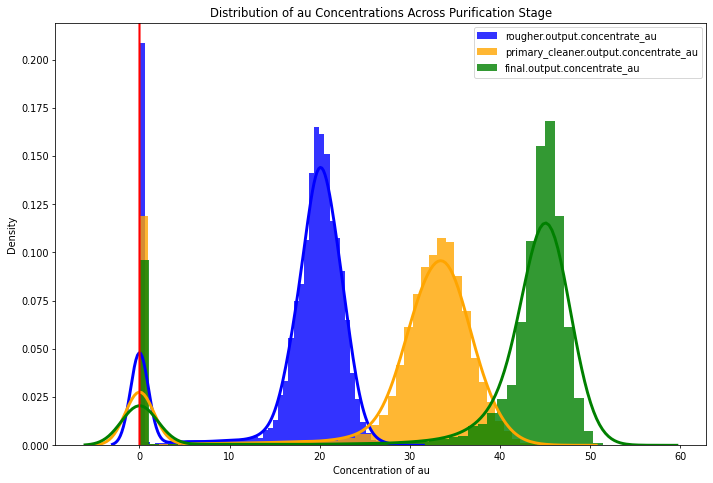

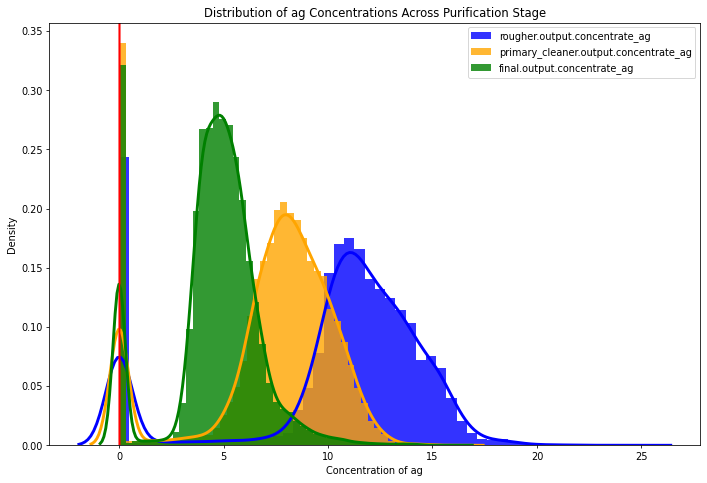

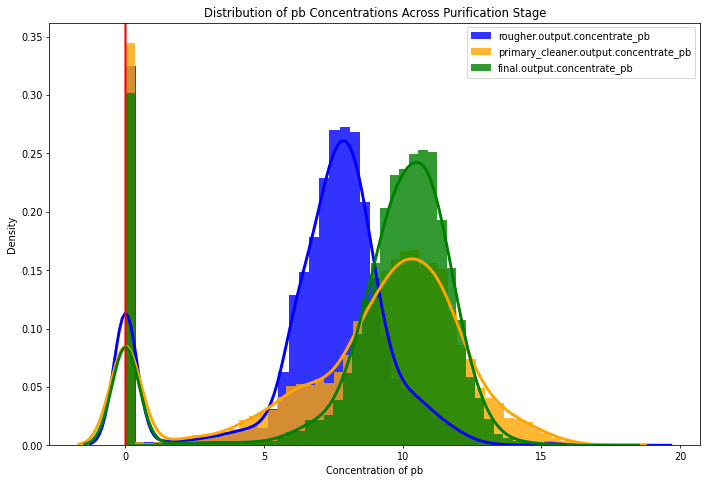

In [601]:
metals = ['au', 'ag', 'pb']
parameters = ['rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']
colors = ['blue', 'orange', 'green']

# Creating function to plot distribution of concentrations 
def plot_distribution(df):
  kwargs = dict(hist_kws={'alpha':0.8}, kde_kws={'linewidth':3})
  for element in metals:
    plt.figure(figsize=(12,8), dpi=70)
    for features, colour in zip(parameters, colors):
      sns.distplot(df[features+'_'+element], color=colour, label=features+'_'+element, **kwargs)
      plt.axvline(0, c='r')
      plt.title('Distribution of ' +element+ ' Concentrations Across Purification Stage')
      plt.xlabel('Concentration of ' +element)
      plt.legend()

# Plotting distribution of concentration of metals in training set
plot_distribution(df_train)

Based on the graph, the concentrations of gold (Au) increases during the final output. This shows that the purification process is functioning properly. The concentration of the other two metals (Ag and Pb) either decreased or increased during the final stage. 

### Comparing feed particle size distributions in the training set and test set

In [602]:
# Average particle size for rougher input in training and test set
print('Average particle size for rougher input in training set: {:.3f}'.format(df_train['rougher.input.feed_size'].mean()))
print('Average particle size for rougher input in test set: {:.3f}'.format(df_test['rougher.input.feed_size'].mean()))

print()

# Average particle size for cleaner input in training and test set
print('Average particle size for primary cleaner input in training set: {:.3f}'.format(df_train['primary_cleaner.input.feed_size'].mean()))
print('Average particle size for primary cleaner input in test set: {:.3f}'.format(df_test['primary_cleaner.input.feed_size'].mean()))

Average particle size for rougher input in training set: 60.189
Average particle size for rougher input in test set: 55.899

Average particle size for primary cleaner input in training set: 7.297
Average particle size for primary cleaner input in test set: 7.265


In [603]:
# Creating function to plot distribution of feed particle size
def plot_particle_size_distribution(df):
    kwargs = dict(hist_kws={'alpha': 0.5}, kde_kws={'linewidth':3})
    plt.figure(figsize=(12,8), dpi=70)
    for features, colour, labels in zip(input_feed, colors, label):
        sns.distplot(features, color=colour, label=labels, **kwargs)
        plt.axvline(0, c="r")
    plt.title('Distribution for Feed Particle Size')
    plt.xlabel('Distribution')
    plt.legend()



/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


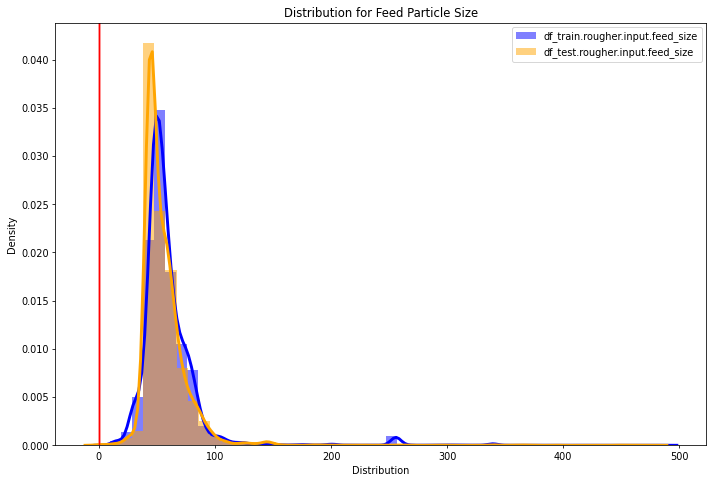

In [604]:
# Plotting distribution of feed particle size for rougher input
input_feed = [df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size']]
label = ['df_train.rougher.input.feed_size', 'df_test.rougher.input.feed_size']
colors = ['blue', 'orange']

plot_particle_size_distribution(df_train)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


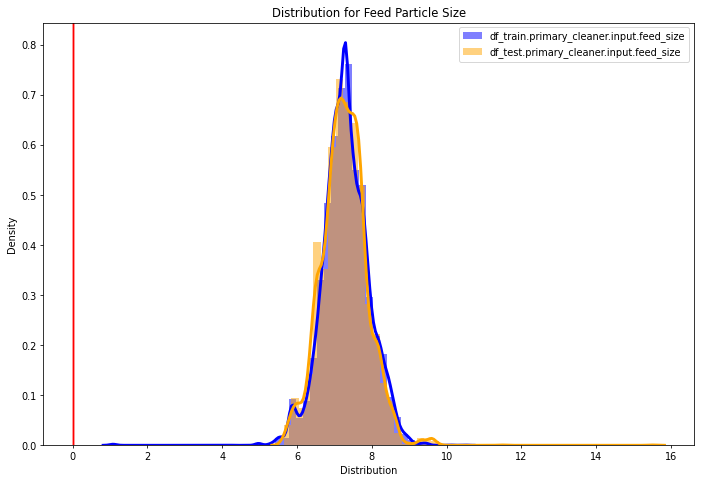

In [605]:
# Plotting distribution of feed particles for cleaner input
input_feed = [df_train['primary_cleaner.input.feed_size'], df_test['primary_cleaner.input.feed_size']]
label = ['df_train.primary_cleaner.input.feed_size', 'df_test.primary_cleaner.input.feed_size']
color = ['blue', 'orange']

plot_particle_size_distribution(df_train)

#### Conclusion
Our graphs show that the particle size distributions are similar for both the `rougher.input.feed_size` and `primary_cleaner.input.feed_size`. The average particle sizes in the rougher.input.feed_size and primary_cleaner.input.feed_size for the training and test set are also close in value. This indicates that we can train our model without any problems. 

### Distribution of total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate

Text(0.5, 1.0, 'Distribution of Total Concentration in Raw Feed')

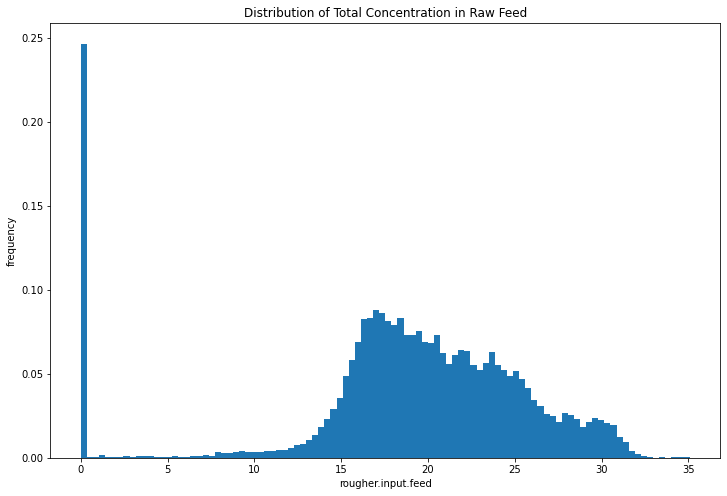

In [606]:
# Raw feed stage (rougher.input.feed)
df_full['rougher.input.feed'] = df_full['rougher.input.feed_au'] + df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_pb']

# Plotting distribution of all substances for raw feed stage 
raw_feed_stage = df_full['rougher.input.feed']
plt.figure(figsize=(12,8))
plt.hist(raw_feed_stage, density=True, bins=100)

# Adding title and axes label
plt.xlabel('rougher.input.feed')
plt.ylabel('frequency')
plt.title('Distribution of Total Concentration in Raw Feed')

The distribution of the total concentration in the raw feed stage is skewed to the left with most values clustered on the right. There is a large spike in concentration at the 0 mark. This means that there are outliers in the data that need to be removed. 


Text(0.5, 1.0, 'Distribution of Total Concentration in Rougher Concentrate')

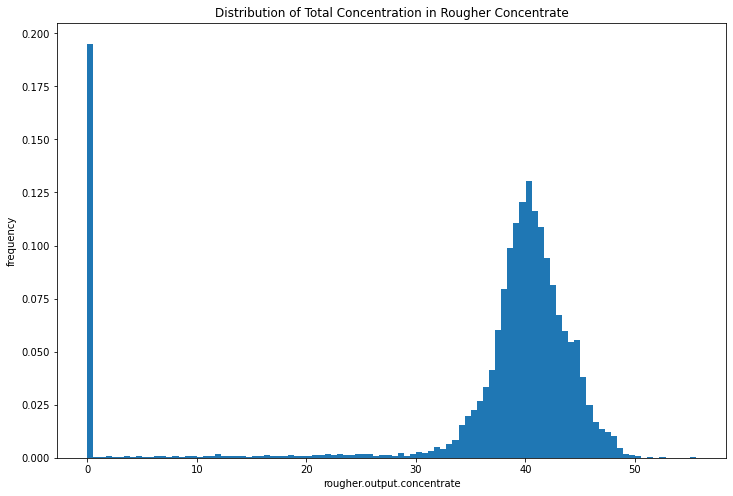

In [607]:
# Rougher concentrate stage (rougher.output.concentrate)
df_full['rougher.output.concentrate'] = df_full['rougher.output.concentrate_au'] + df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_pb']

# Plotting distribution of all substances for rougher concentrate stage 
rougher_concentrate_stage = df_full['rougher.output.concentrate']
plt.figure(figsize=(12,8))
plt.hist(rougher_concentrate_stage, density=True, bins=100)

# Adding title and axes label
plt.xlabel('rougher.output.concentrate')
plt.ylabel('frequency')
plt.title('Distribution of Total Concentration in Rougher Concentrate')

The distribution of the total concentration in the rougher concentrate stage is skewed to the left with most values clustered on the right. There is a large spike in concentration at the 0 mark. This means that there are outliers in the data that need to be removed.

Text(0.5, 1.0, 'Distribution of Total Concentration in Final Concentrate')

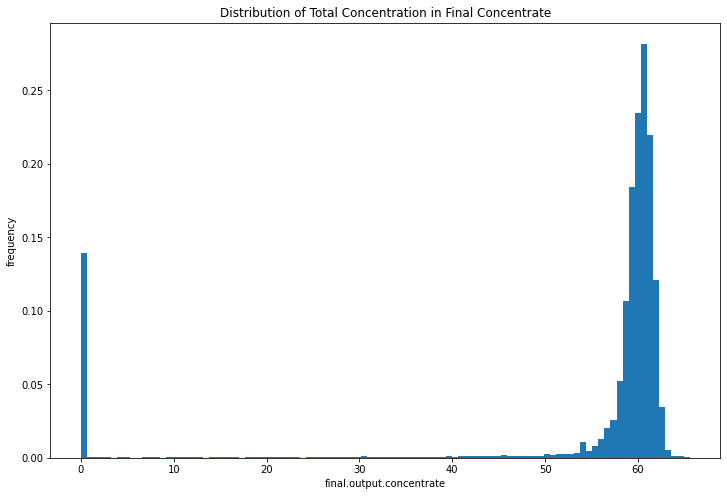

In [608]:
# Final concentrate stage (final.output.concentrate)
df_full['final.output.concentrate'] = df_full['final.output.concentrate_au'] + df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_pb']

# Plotting distribution of all substances for final concentrate stage
rougher_concentrate_stage = df_full['final.output.concentrate']
plt.figure(figsize=(12,8))
plt.hist(rougher_concentrate_stage, density=True, bins=100)

# Adding title and axes label
plt.xlabel('final.output.concentrate')
plt.ylabel('frequency')
plt.title('Distribution of Total Concentration in Final Concentrate')

The distribution of the total concentration in the rougher concentrate stage is skewed to the left with most values clustered on the right. There is a large spike in concentration at the 0 mark. This means that there are outliers in the data that need to be removed.

In [609]:
# Creating filtered dataset without outliers
df_full_filtered = df_full[(df_full['rougher.input.feed'] > 1) & (df_full['rougher.output.concentrate'] > 1) & (df_full['final.output.concentrate'] > 1)]

# Getting number of rows and columns of filtered dataset
print('Shape of df_full_filtered:', df_full_filtered.shape)

Shape of df_full_filtered: (19896, 90)


In [610]:
# Making date the index of the datasets
df_train.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)
df_full_filtered.set_index('date', inplace=True)

We use this new index to filter out outliers in the training set and test set. 

In [611]:
# Index of df_train in df_full
df_train_index_filter = df_full_filtered.index.intersection(df_train.index)

# Filtering out outliers in df_train
df_train_filtered = df_full_filtered.loc[df_train_index_filter]
df_train_filtered.reset_index(inplace=True)

# Getting number of rows and columns of filtered dataset
print('Shape of df_train_filtered:', df_train_filtered.shape)

Shape of df_train_filtered: (14608, 90)


In [612]:
# Index of df_test in df_full
df_test_index_filter = df_full_filtered.index.intersection(df_test.index)

# Filtering out outliers in df_test
df_test_filtered = df_full_filtered.loc[df_test_index_filter]
df_test_filtered.reset_index(inplace=True)

# Getting number of rows and columns of filtered dataset
print('Shape of df_train_filtered:', df_test_filtered.shape)

Shape of df_train_filtered: (5288, 90)


#### Conclusion 
We checked for outliers in the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. There was a spike in frequency at the value 0, which indicated abnormal values in total distribution. We removed the outliers and created new filtered datasets for `df_full`, `df_train`, and `df_test`. 

Using our filtered datasets, we can now train different models to calculate sMAPE.


## Model Building

In [613]:
# Creating function to calculate the symmetric mean absolute percentage error (sMAPE)
def smape (actual, predicted):
  smape =  1/len(actual) * np.sum(2 * np.abs(predicted-actual)/(np.abs(actual) + np.abs(predicted)) * 100)
  return smape

# Creating function to calcualte final sMAPE
def final_smape(actual, predicted):
  smape_rougher = smape(actual[:,0], predicted[:,0])
  smape_final = smape(actual[:,1], predicted[:,1])
  final_smape = ((0.25 * smape_rougher) + (0.75 * smape_final))
  return final_smape

# Creating user-defined scoring function
smape_score = make_scorer(final_smape, greater_is_better=False)

In [614]:
# Declaring variables for features  
features_train = df_train_filtered.drop(features_diff, axis=1)
features_train = features_train.drop(['date','rougher.output.concentrate','final.output.concentrate'], axis=1)
features_test = df_test_filtered.drop(features_diff, axis=1)
features_test = features_test.drop(['date','rougher.output.concentrate','final.output.concentrate'], axis=1)

# Declaring variables for target
target_train = df_train_filtered[['rougher.output.recovery', 'final.output.recovery']]
target_test = df_test_filtered[['rougher.output.recovery', 'final.output.recovery']]

In [615]:
# Tranforming taget data into numpy array 
target_train = target_train.values
target_test = target_test.values

In [616]:
# Creating a baseline model
dr = DummyRegressor()
dr.fit(features_train, target_train)
dr_pred = dr.predict(features_test)
print('Baseline sMAPE = {:.2f}%'.format(smape(target_test, dr_pred)))
print('Baseline final sMAPE score = {:.2f}%'.format(final_smape(target_test, dr_pred)))

Baseline sMAPE = 15.12%
Baseline final sMAPE score = 8.29%


The symmetric mean absolute percentage error (sMAPE) is used to measure the predictive accuracy of models. The smaller the value for sMAPE, the better the predictive accuracy of a given model. The final sMAPE score for our baseline model is 8.29%. We will try to improve the score by training different models and evaluating them using cross-validation. 

In [617]:
# Creating pipeline for linear regression model
pipeline_lr = Pipeline([('scaler', StandardScaler()),('linear_regression', LinearRegression())])
pipeline_lr.fit(features_train, target_train)

# Performing cross-validation 
cv_score_lr = cross_val_score(pipeline_lr, features_train, target_train, cv=5, scoring=smape_score)
print('sMAPE range of values:', cv_score_lr)

# Calculating sMAPE
pipeline_lr_pred = pipeline_lr.predict(features_test)
print('sMAPE = {:.2f}%'.format(smape(target_test, pipeline_lr_pred)))
print('Final sMAPE score = {:.2f}%'.format(final_smape(target_test, pipeline_lr_pred)))

sMAPE range of values: [-13.14822528 -10.0541952   -9.61917146  -9.0172931  -13.84557208]
sMAPE = 14.05%
Final sMAPE score = 7.96%


In [618]:
# Creating pipeline for decision tree regression model
pipeline_dtr = Pipeline([('scaler', StandardScaler()),('decision_tree', DecisionTreeRegressor())])
pipeline_dtr.fit(features_train, target_train)

# Performing cross-validation 
cv_score_dtr = cross_val_score(pipeline_dtr, features_train, target_train, cv=5, scoring=smape_score)
print('sMAPE range of values:', cv_score_dtr)

/tmp/ipykernel_36/1818198077.py:3: RuntimeWarning: invalid value encountered in true_divide
  smape =  1/len(actual) * np.sum(2 * np.abs(predicted-actual)/(np.abs(actual) + np.abs(predicted)) * 100)


sMAPE range of values: [         nan -18.22441073 -14.86595086 -18.08474728 -14.99600243]


In [619]:
# Tuning hyperparameter max_depth for decision tree regression model
for depth in range (1,6):
  model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
  model.fit(features_train, target_train)
  prediction_test = model.predict(features_test)
  cv_score = cross_val_score(model, features_train, target_train, cv=5, scoring=smape_score)
  print('max_depth =', depth, ':', end='')
  print(cv_score.mean())

max_depth = 1 :-9.933181224586654
max_depth = 2 :-9.944154218533319
max_depth = 3 :-9.787576191054129
max_depth = 4 :-10.187897487207698
max_depth = 5 :-10.256753999363463


In [620]:
# Creating decision tree regression model with hyperparameter tuning
pipeline_dtr = Pipeline([('scaler', StandardScaler()),('decision_tree', DecisionTreeRegressor(random_state=12345, max_depth=1))])
pipeline_dtr.fit(features_train, target_train)

# Performing cross-validation 
cv_score_dtr = cross_val_score(pipeline_dtr, features_train, target_train, cv=5, scoring=smape_score)
print('sMAPE range of values:', cv_score_dtr)

# Calculating sMAPE score
dtr_pred = pipeline_dtr.predict(features_test)
print('sMAPE = {:.2f}%'.format(smape(target_test, dtr_pred)))
print('Final sMAPE score = {:.2f}%'.format(final_smape(target_test, dtr_pred)))

sMAPE range of values: [-10.59122692  -8.0250326   -9.62872192  -9.57824608 -11.84267861]
sMAPE = 13.69%
Final sMAPE score = 7.62%


In [621]:
# Creating pipeline for random forest regression model
pipeline_rfr = Pipeline([('scaler', StandardScaler()),('random_forest', RandomForestRegressor())])
pipeline_rfr.fit(features_train, target_train)

# Performing cross-validation 
cv_score_rfr = cross_val_score(pipeline_rfr, features_train, target_train, cv=5, scoring=smape_score)
print('sMAPE range of values:', cv_score_rfr)

sMAPE range of values: [-11.08410467  -9.46691089  -9.33163292 -10.69315642 -11.10219584]


In [622]:
# Tuning hyperparameter n_estimators for random forest regression model
pipe_params = {'random_forest__n_estimators':[10,15,20,25]}
model = RandomForestRegressor(random_state=12345)
search = GridSearchCV(pipeline_rfr, param_grid=pipe_params, scoring=smape_score)
search.fit(features_train, target_train)
print('The best hyperparameters are: {}'.format(search.best_params_))


        

The best hyperparameters are: {'random_forest__n_estimators': 25}


In [623]:
# Creating random forest regression model with hyperparameter tuning
pipeline_rfr = Pipeline([('scaler', StandardScaler()),('random_forest', RandomForestRegressor(random_state=12345, n_estimators=15))])
pipeline_rfr.fit(features_train, target_train)

# Performing cross-validation 
cv_score_rfr = cross_val_score(pipeline_rfr, features_train, target_train, cv=5, scoring=smape_score)
print('sMAPE range of values:', cv_score_dtr)

# Calculating sMAPE score
rfr_pred = pipeline_rfr.predict(features_test)
print('sMAPE = {:.2f}%'.format(smape(target_test, rfr_pred)))
print('Final sMAPE score = {:.2f}%'.format(final_smape(target_test, rfr_pred)))

sMAPE range of values: [-10.59122692  -8.0250326   -9.62872192  -9.57824608 -11.84267861]
sMAPE = 15.45%
Final sMAPE score = 8.19%


#### Conclusion 
We created two functions to calculate the symmetric mean absolute percentage error (sMAPE) and the final symmetric mean absolute percentage error (final sMAPE). sMAPE is used to measure the predictive accuracy of models. The smaller the value for SMAPE, the better the predictive accuracy of a given model. For our baseline model, we obtained a final sMAPE score of 8.29%. Three different regression models were then trained and evaluated with k-fold cross validation as a means of improving the sMAPE score. 
* For the linear regression model, we obtained a sMAPE score of 14.05% and a final sMAPE score of 7.96%
* We trained two different decision tree regression models: one where we  didn’t tune the hyperparameters and one where we tuned the hyperparameters. After hyperparameter tuning, we obtained a sMAPE score of 13.69% and a final sMAPE score of 7.62% 
* We also trained two different random forest regression models: one where we didn’t tune the hyperparameters and one where we tuned the hyperparameters. After hyperparameter tuning, we obtained a sMAPE score of 15.45% and a final sMAPE score of 8.19%. 

The best model for our data was the decision tree regression model with a sMAPE score of 7.62%.


## Findings

We simulated the process of recovering gold from gold ore by calculating recovery. We then used the calculated recovery values to calculate the mean absolute error (MAE). We obtained an MAE score close to zero. This means that the calculated recovery values from our simulated recovery process are very similar to the values in `rougher.output.recovery` feature.

We plotted the distribution of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage. Based on our graph, the concentrations of gold (Au) increased during the final output. This means that the purification process is functioning properly. The concentration of the other two metals (Ag and Pb) either decreased or increased during the final stage. We also compared the feed particle size distributions in the training set and in the test set. We found the average particle size for rougher and primary cleaner input in both the training set and test set:
* Average particle size for rougher input in training set: 60.189
* Average particle size for rougher input in test set: 55.899
* Average particle size for primary cleaner input in training set: 7.297
* Average particle size for primary cleaner input in test set: 7.265

We plotted graphs that showed that compared the particle size distributions in both the training and test set. Our graph further showed that the particle size distributions were similar for both the `rougher.input.feed_size` and `primary_cleaner.input.feed_size`. This indicated that we could train our model without any problems.

We also considered the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. We plotted the distribution of total concentration at the different stages to check for outliers.  We found that there was a spike in frequency at the value 0 for all three stages. This indicated that there were abnormal values in total distribution. To deal with this, we removed the outliers and created new filtered datasets. Our new filtered datasets were then used to build and train our models.

We created two functions to calculate the symmetric mean absolute percentage error (sMAPE) and the final symmetric mean absolute percentage error (final sMAPE). For our baseline model, we obtained a final sMAPE score of 8.29%. Three different regression models were then trained and evaluated with k-fold cross validation as a means of improving the sMAPE score. 
* For the linear regression model, we obtained a sMAPE score of 14.05% and a final sMAPE score of 7.96%
* After hyperparameter tuning of the decision tree regression model, we obtained a sMAPE score of 13.69% and a final sMAPE score of 7.62%
* After hyperparameter tuning of the random forest model, we obtained a sMAPE score of 15.45% and a final sMAPE score of 8.19% 

The best model for our data was the decision tree regression model with a final sMAPE score of 7.62%.
